<a href="https://colab.research.google.com/github/zerxe/CEIABDAT/blob/main/SNS/Actividad_3_4_%E2%80%93_Representaci%C3%B3n_plot_de_datasets%2C_selecci%C3%B3n_de_caracter%C3%ADsticas_y_entrenamiento_de_modelos_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Actividad 3.4 – Representación plot de datasets, selección de características y entrenamiento de modelos.


Adolfo Morales Colmenares

El objetivo de esta actividad es poner en práctica los conocimientos adquiridos para el
preprocesamiento de datos, selección de características y entrenamiento de modelos.
Para ello es necesario seleccionar un Dataset que consideres oportuno, de clasificación o
regresión, y distinto a los utilizados en clase.
Los puntos a desarrollar son los siguientes:

## 1. (5%) Describir el origen y breve explicación del Dataset, así como de cada una de las características.

**Origen:** El dataset fue creado por Luis M. Candanedo y se encuentra en Kaggle bajo el nombre "Room Occupancy Detection Data". Este dataset contiene datos recolectados de sensores IoT para predecir la ocupación de una habitación.


**Descripción breve:** El objetivo principal del dataset es predecir si una habitación está ocupada (1) o no (0) en función de lecturas de sensores ambientales.

**Características:**
* **date:** Marca temporal (**fecha y hora**).
* **Temperature:** Temperatura en grados **Celsius**.
* **Humidity:** Humedad relativa (**%**).
* **Light:** Nivel de iluminación (**lux**).
* **CO2:** Concentración de dióxido de carbono (**ppm**).
* **HumidityRatio:** Relación de humedad absoluta.
* **Occupancy:** Variable objetivo (**0 = No ocupada, 1 = Ocupada**).

## Imports


In [22]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Dataset

In [23]:
path = kagglehub.dataset_download("kukuroo3/room-occupancy-detection-data-iot-sensor")
print("Path to dataset files:", path)

dataset_path = f"{path}/Occupancy.csv"

data = pd.read_csv(dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/kukuroo3/room-occupancy-detection-data-iot-sensor/versions/2


## 2. (5%) Procesamiento de datos en el dataset: ajustes en características con datos no informados, conversión de variables categóricas, etc…

In [24]:
# Descripción inicial
data.info()
print("\nPrimeras filas del dataset:")
print(data.head())

# Breve explicación de las características
print("\nDescripción estadística del dataset:")
print(data.describe())

# Verificar valores faltantes
print("\nValores faltantes por columna:")
print(data.isnull().sum())

# Convertir la columna de fecha en características adicionales
data['date'] = pd.to_datetime(data['date'])
data['hour'] = data['date'].dt.hour
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data.drop('date', axis=1, inplace=True)

# Verificar outliers usando el método IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

for col in ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']:
    data = remove_outliers(data, col)

# Eliminar características constantes
constant_features = [col for col in data.columns if data[col].nunique() == 1]
data.drop(columns=constant_features, inplace=True)

# Separar características y objetivo
X = data.drop('Occupancy', axis=1)
y = data['Occupancy']

# Escalar los datos para algunas técnicas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB

Primeras filas del dataset:
                  date  Temperature  Humidity       Light         CO2  \
0  2015-02-02 14:19:00      23.7000    26.272  585.200000  749.200000   
1  2015-02-02 14:19:59      23.7180    26.290  578.400000  760.400000   
2  2015-02-02 14:21:00      23.7300    26.230  572.666667  769.666667   
3  2015-02-02 14:22:00      23.7225    26.125  493.750000  774.750000   
4  2015-02-02 14:23:00      23.7540    2

## 3. Utilizar las siguientes herramientas explicadas en clase para la selección de características:




### 3.1. (10%) Matriz de gráficos de correlación.

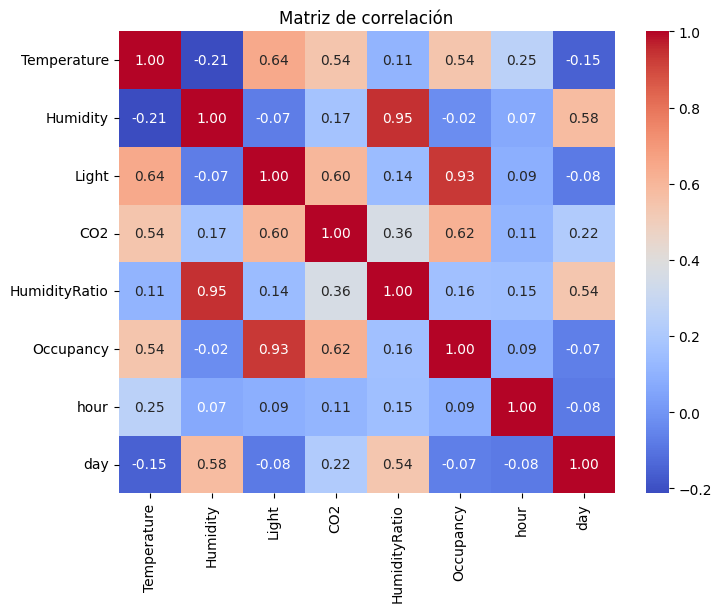

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

### 3.2. (10%) Matriz de gráficos de dispersión.

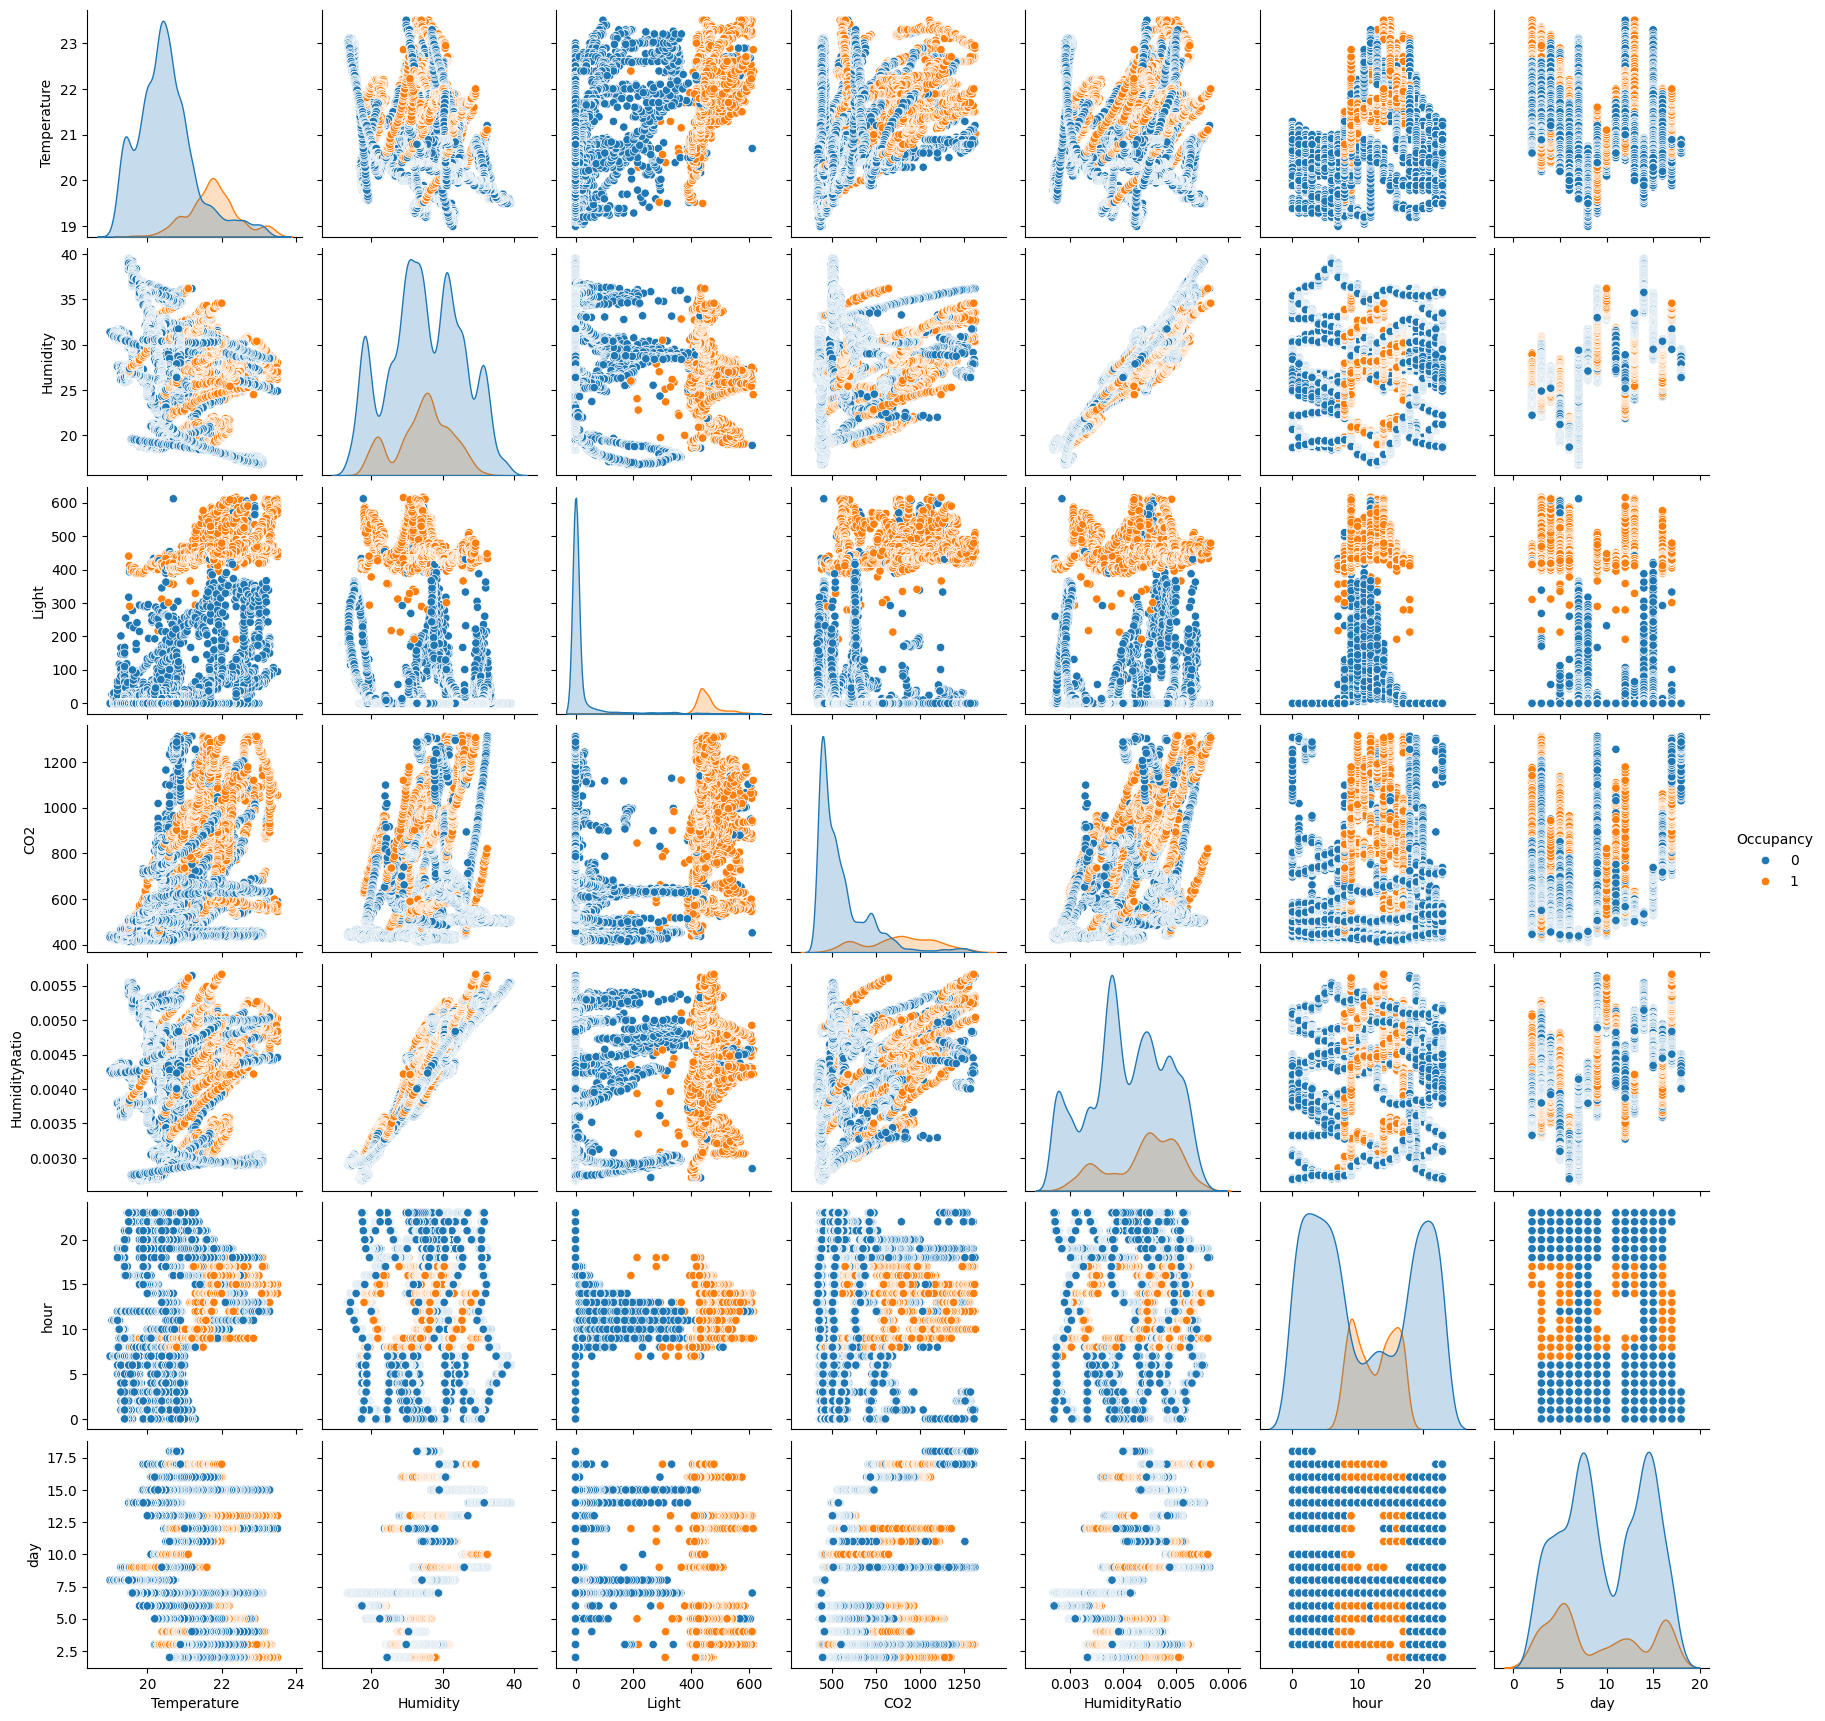

In [26]:
sns.pairplot(data, hue='Occupancy', diag_kind='kde')
plt.show()

### 3.3. (10%) SelectKBest.

In [27]:
f_selector = SelectKBest(score_func=f_classif, k=5)
X_kbest_f = f_selector.fit_transform(X_scaled, y)

print("\nPuntuaciones de F-score (ANOVA):")
print(f_selector.scores_)


Puntuaciones de F-score (ANOVA):
[7.66030223e+03 1.06216058e+01 1.16438697e+05 1.13758494e+04
 4.74892519e+02 1.34640596e+02 9.16216796e+01]


## 4. (5%) Una pequeña reflexión sobre la elección de las características elegidas.

In [33]:
f_selected_features = X.columns[f_selector.get_support()]
print(f"\nCaracterísticas seleccionadas con F-score: {list(f_selected_features)}")


Características seleccionadas con F-score: ['Temperature', 'Light', 'CO2', 'HumidityRatio', 'hour']


## 5. Con las librerías para NaiveBayes vistas en clase, entrenar el modelo que consideres más adecuado.

In [29]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### 5.1. (10%) Sin utilizar Cross Validation.

In [30]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

print("\nResultados sin Cross Validation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Resultados sin Cross Validation:
[[4287  103]
 [   5 1106]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4390
           1       0.91      1.00      0.95      1111

    accuracy                           0.98      5501
   macro avg       0.96      0.99      0.97      5501
weighted avg       0.98      0.98      0.98      5501

Accuracy: 0.98


### 5.2. (15%) Utilizando Cross Validation.

In [31]:
cv_scores = cross_val_score(nb_model, X_scaled, y, cv=5, scoring='accuracy')
print("\nResultados con Cross Validation:")
print(f"Scores: {cv_scores}")
print(f"Promedio de Accuracy: {cv_scores.mean():.2f}")


Resultados con Cross Validation:
Scores: [0.96863921 0.95091355 0.99700027 0.99563676 0.97026732]
Promedio de Accuracy: 0.98


## 6. (5%) Obtener una conclusión sobre los resultados obtenidos en la predicción y evaluación al utilizar o no Cross Validation.

**Conclusión**: La validación cruzada proporciona una evaluación más robusta del modelo, reduciendo la dependencia en una única partición de datos.
En este caso el **accuracy** es igual pero de igual manera generalmente es recomendable usar cross validation.

## 7. (10%) Además de las herramientas indicadas anteriormente, se valorará la utilización de alguna otra herramienta o técnica no vista en el curso para la selección de las características.


Varianza explicada por los componentes principales:
[0.36966443 0.31476167]


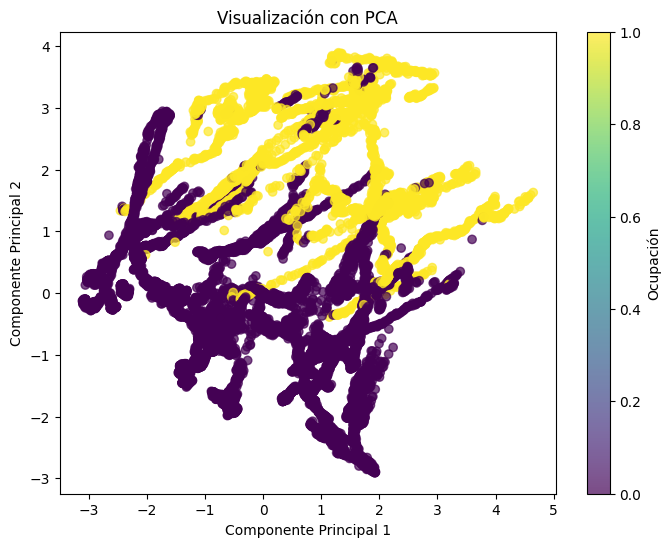

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("\nVarianza explicada por los componentes principales:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización con PCA')
plt.colorbar(label='Ocupación')
plt.show()